In [1]:
    
from mesa.space import MultiGrid
from mesa import Model
from mesa.time import RandomActivation
import numpy as np
from queue import Queue

class ElFarolBar(Model):
    def __init__(self, crowdthreshold=60,num_strategies=10,memory_size = 10,width = 100,height = 100,N=100):
        self.running = True 
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)
        self.history = np.random.randint(0,100,size = memory_size*2).tolist()
        self.attendance = self.history[-1]
        strategies = np.random.rand(num_strategies,memory_size+1,N)*2-1
        for i in range(self.num_agents):
            a = BarCustomer(i,self, num_strategies,memory_size,crowdthreshold,strategies[:,:,i]) 
            self.schedule.add(a)
        self.datacollector = DataCollector(
            model_reporters ={'Customers':"attendance"},
            agent_reporters={"Utility": "utility","Attendance":"attend"})
        
    def step(self):
        self.datacollector.collect(self)
        self.attendance = 0
        self.schedule.step()
        self.history.pop(0)
        self.history.append(self.attendance)
        for agent in self.schedule.agent_buffer(shuffled=False):
            agent.update_strategies()
        


In [2]:
from mesa import Agent
from mesa.datacollection import DataCollector

class BarCustomer(Agent):
    def __init__(self, unique_id, model,num_strategies,memory_size,crowdthreshold,strategies):
        super().__init__(unique_id, model)
#        random.seed = random.randint(0,1000)
        self.strategies = strategies
        self.best_strategy = self.strategies[0]
        self.attend = False
        self.memory_size = memory_size
        self.crowdthreshold = crowdthreshold
        self.utility = 0 
        self.update_strategies()

    #need to add step method here, to activate make_decision
    def step(self):
        prediction = self.predict_attendance(self.best_strategy,self.model.history[-self.memory_size:])
        #print(prediction)
        if prediction<=self.crowdthreshold:
            self.attend = True
            self.model.attendance = self.model.attendance +1
        else: 
            self.attend = False
    
    def update_strategies(self):
        best_score = float('inf')
        for strategy in self.strategies:
            score, week = 0,0
            for _ in range(self.memory_size):
                prediction = self.predict_attendance(strategy,\
                                                     self.model.history[week:week+self.memory_size])
                score = score + abs(self.model.history[week+self.memory_size]-prediction)
                week = week + 1
            if score <= best_score:
                best_score = score
                self.best_strategy = strategy
        #print(best_score)
        if (self.model.history[-1]>self.crowdthreshold and self.attend ==True) or (self.model.history[-1]<self.crowdthreshold and self.attend ==False):
            self.utility = self.utility -1 
        else:
            self.utility = self.utility +1 
    
    def predict_attendance(self,strategy,subhistory):
        #print(strategy[1:],subhistory,strategy[0],strategy[0]*100+ sum(strategy[1:]*subhistory))
        return strategy[0]*100+ sum(strategy[1:]*subhistory)

In [3]:
models = [ElFarolBar(N=100,crowdthreshold=60,memory_size=m) for m in [5,10,20]]
for model in models:
    for i in range(400):
        model.step()

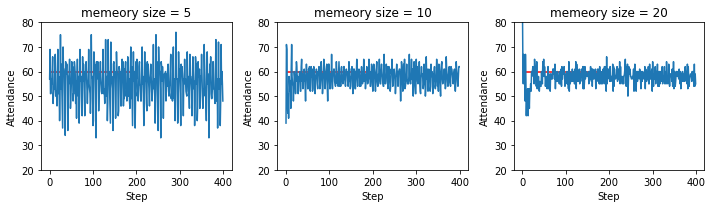

In [6]:
import matplotlib.pyplot as plt
n =60
plt.figure(figsize = (10,3))
ms = [5,10,20]
for idx in range(3):
    model = models[idx]
    plt.subplot(1,3,idx+1)
    df = model.datacollector.get_model_vars_dataframe()
    plt.plot(df['Customers'])
    plt.xlabel('Step')
    plt.ylabel('Attendance')
    plt.ylim([20,80])
    plt.title('memeory size = '+str(ms[idx]))
    plt.hlines(n,0,200,'r')
    plt.tight_layout()
plt.savefig('memorysize.png',dpi = 300)

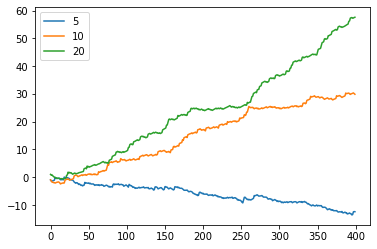

In [7]:
for idx in range(len(ms)):
    model = models[idx]
    df = model.datacollector.get_agent_vars_dataframe()
    plt.plot(df['Utility'].groupby('Step').mean(),label = str(ms[idx]))
plt.legend()

No handles with labels found to put in legend.


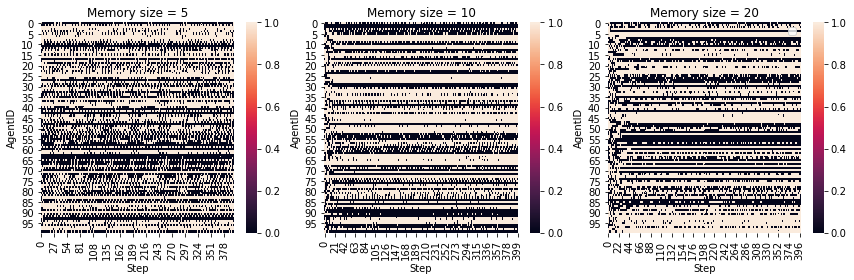

In [13]:
import seaborn as sns
plt.figure(figsize = (12,4))
for idx in range(len(ms)):
    plt.subplot(1,3,idx+1)
    model = models[idx]
    df = model.datacollector.get_agent_vars_dataframe()
    df.reset_index(inplace=True)
    sns.heatmap(df.pivot(index = "AgentID",columns = "Step",values = "Attendance"))
    plt.tight_layout()
    plt.title('Memory size = '+str(ms[idx]))
plt.legend()
plt.savefig('Memorysize.heatmap.png')

In [181]:
nss = [5,10,20]
n =60

models = [ElFarolBar(N=100,crowdthreshold=n,num_strategies=ns) for ns in nss]
for model in models:
    for i in range(400):
        model.step()
        

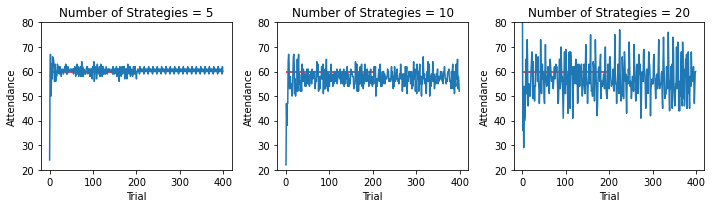

In [182]:
plt.figure(figsize = (10,3))

for idx in range(len(nss)):
    model = models[idx]
    plt.subplot(1,3,idx+1)
    df = model.datacollector.get_model_vars_dataframe()
    plt.plot(df['Customers'])
    plt.xlabel('Trial')
    plt.ylabel('Attendance')
    plt.ylim([20,80])
    plt.title('Number of Strategies = '+str(nss[idx]))
    plt.hlines(n,0,200,'r')
    plt.tight_layout()
plt.savefig('builtin_model.png',dpi = 300)

In [15]:
class ElFarolBarIBLT(Model):
    def __init__(self, crowdthreshold=60,decay={1:1},memory_size = 10,width = 100,height = 100,N=100):
        self.running = True 
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, True)
        self.history = np.random.randint(0,100,size = memory_size*2).tolist()
        self.attendance = self.history[0]
        i =0
        for d,portion in decay.items():
            for _ in range(int(self.num_agents*portion)):
                a = BarCustomerIBLT(i,self,d,crowdthreshold) 
                self.schedule.add(a)
                i = i+1
        self.datacollector = DataCollector(
            model_reporters ={'Customers':"attendance"},
            agent_reporters={"Utility": "utility","Decay":"decay","Attendance":"attend"})
    def step(self):
        self.datacollector.collect(self)
        self.attendance = 0
        self.schedule.step()
        self.history.pop(0)
        
        self.history.append(self.attendance)
        for agent in self.schedule.agent_buffer(shuffled=False):
            agent.update_strategies()

In [16]:
##Cognitive based model IBLT 
import pyibl 
import random
class BarCustomerIBLT(Agent):
    def __init__(self, unique_id, model,decay,crowdthreshold):
        super().__init__(unique_id, model)
        self.agent = pyibl.Agent("BarCustomer",["Attendence"],decay = decay,noise = random.uniform(0.1,1.5))
        self.agent.default_utility=10
        self.attend = False
        self.utility = 0
        self.decay = decay
        self.crowdthreshold = crowdthreshold
        self.step()
        self.update_strategies()
        

    #need to add step method here, to activate make_decision
    def step(self):
        choise = self.agent.choose('Attend','Not Attend')
        if choise =='Attend':
            self.attend = True
            self.model.attendance = self.model.attendance +1
        else: 
            self.attend = False
    
    def update_strategies(self):
        if (self.model.history[-1]>self.crowdthreshold and self.attend ==True) or (self.model.history[-1]<self.crowdthreshold and self.attend ==False):
            self.agent.respond(-1)
            self.utility = self.utility -1 
        else:
            self.agent.respond(1)
            self.utility = self.utility +1 


In [174]:
n = 50
trials = 400
models = [ElFarolBarIBLT(N=100,crowdthreshold=n,decay = {0.1:1}),
         ElFarolBarIBLT(N=100,crowdthreshold=n,decay = {1:1}),
        ElFarolBarIBLT(N=100,crowdthreshold=n,decay = {2.5:1}),
        ElFarolBarIBLT(N=100,crowdthreshold=n,decay = {5:1})]

for model in models:
    for i in range(trials):
        model.step()

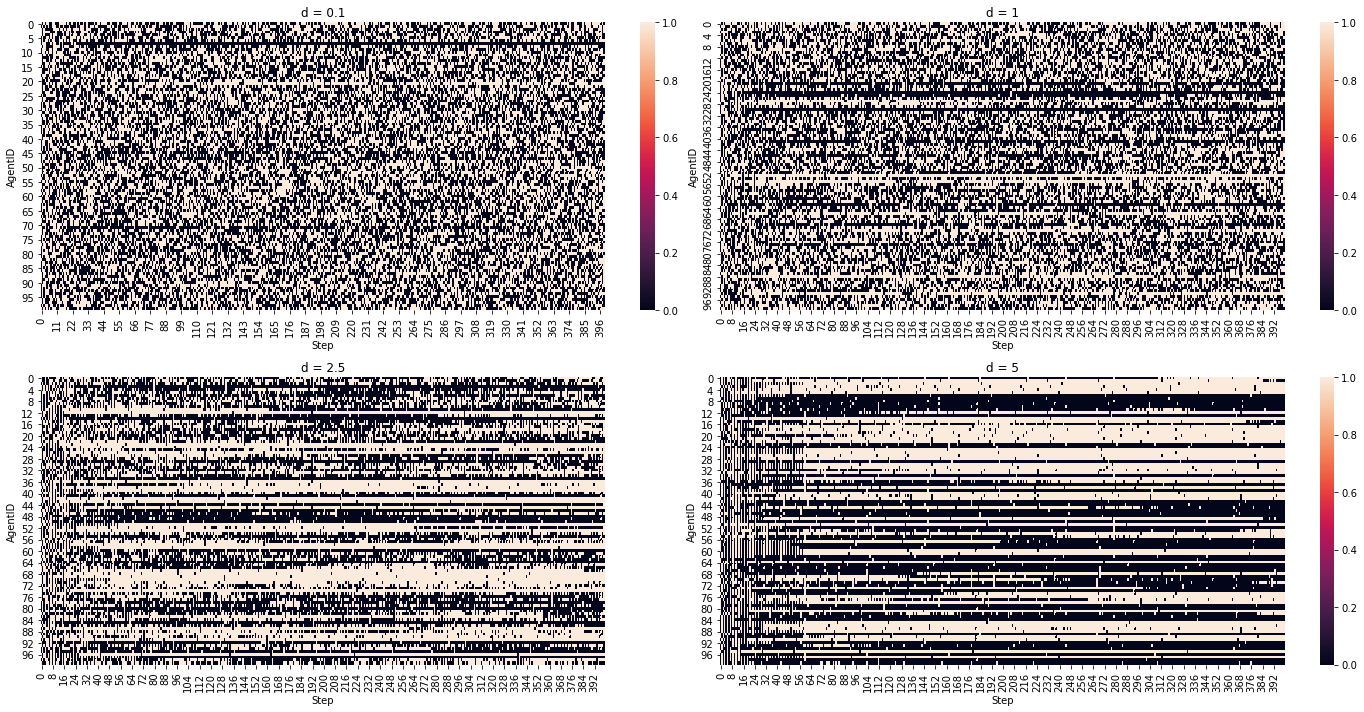

In [178]:
import seaborn as sns
d = [0.1,1,2.5,5]
plt.figure(figsize = (20,10))
for idx in range(4):
    plt.subplot(2,2,idx+1)
    model = models[idx]
    df = model.datacollector.get_agent_vars_dataframe()
    df.reset_index(inplace=True)
    sns.heatmap(df.pivot(index = "AgentID",columns = "Step",values = "Attendance"))
    plt.tight_layout()
    plt.title('d = '+str(d[idx]))
plt.savefig('attendance.homogenious.png',dpi= 300)

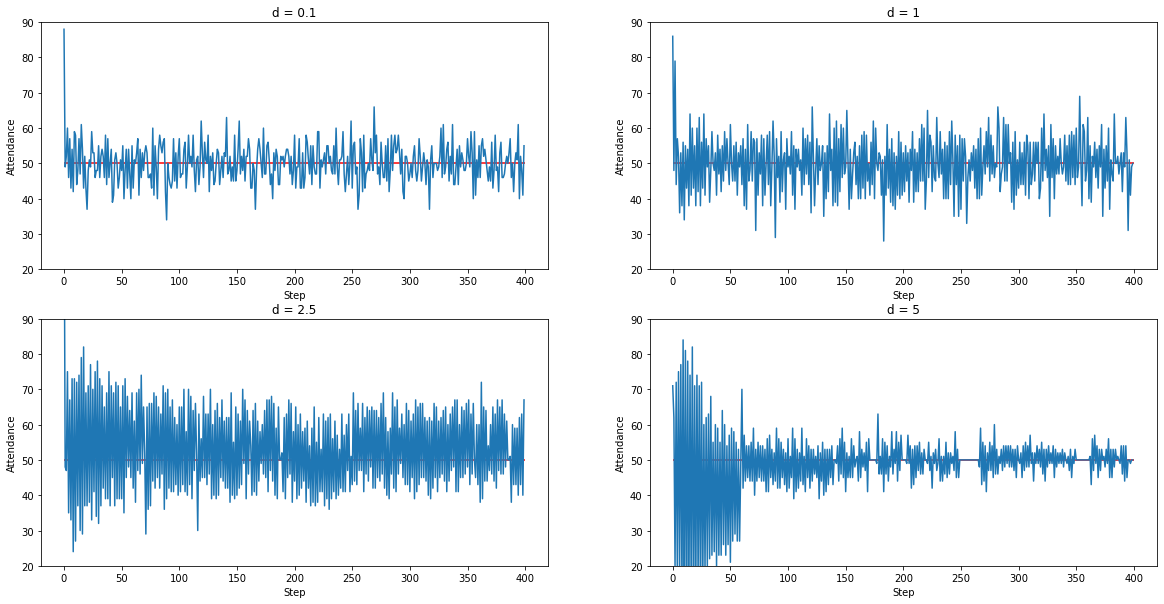

In [179]:
d = [0.1,1,2.5,5]
plt.figure(figsize = (20,10))
for idx in range(4):
    plt.subplot(2,2,idx+1)
    model = models[idx]
    df = model.datacollector.get_model_vars_dataframe()
    plt.plot(df['Customers'],label = str(d[idx]))
    plt.ylim([20,90])
    plt.title('d = '+str(d[idx]))
    plt.hlines(n,0,400,'r')
    plt.xlabel('Step')
    plt.ylabel('Attendance')
plt.savefig('cog_homogenious.png',dpi = 300)

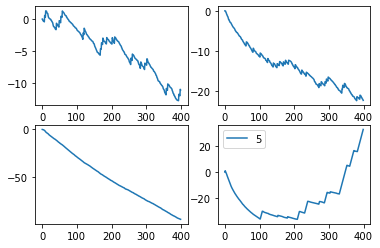

In [99]:
import matplotlib.pyplot as plt
d = [0.1,1,2.5,5]
for idx in range(4):
    plt.subplot(2,2,idx+1)
    model = models[idx]
    df = model.datacollector.get_agent_vars_dataframe()
    plt.plot(df['Utility'].groupby('Step').mean(),label = str(d[idx]))
plt.legend()

In [17]:
n = 60
trials = 400
decays ={'90:10':{0.1:0.9,2.5:0.1},
        '75:25':{0.1:0.75,2.5:0.25},
        '50:50':{0.1:0.5,2.5:0.5},
        '25:75':{0.1:0.25,2.5:0.75},
        '10:90':{0.1:0.1,2.5:0.9}}
models = {name:ElFarolBarIBLT(N=100,crowdthreshold=n,decay = d) for name,d in decays.items()}

for _,model in models.items():
    for i in range(trials):
        model.step()

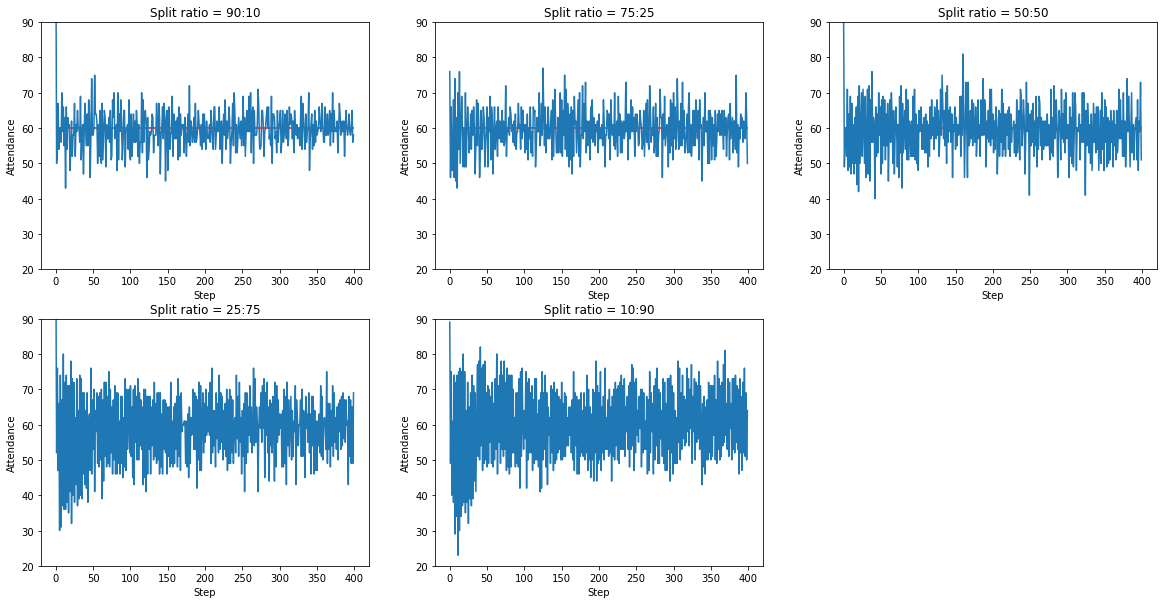

In [20]:
plt.figure(figsize = (20,10))
idx = 1
for name,model in models.items():
    plt.subplot(2,3,idx)
    df = model.datacollector.get_model_vars_dataframe()
    plt.plot(df['Customers'],label = name)
    plt.ylim([20,90])
    plt.title('Split ratio = '+name)
    plt.hlines(n,0,400,'r')
    idx = idx + 1 
    plt.xlabel('Step')
    plt.ylabel('Attendance')
plt.savefig('Heterogeneity.png',dpi = 300)

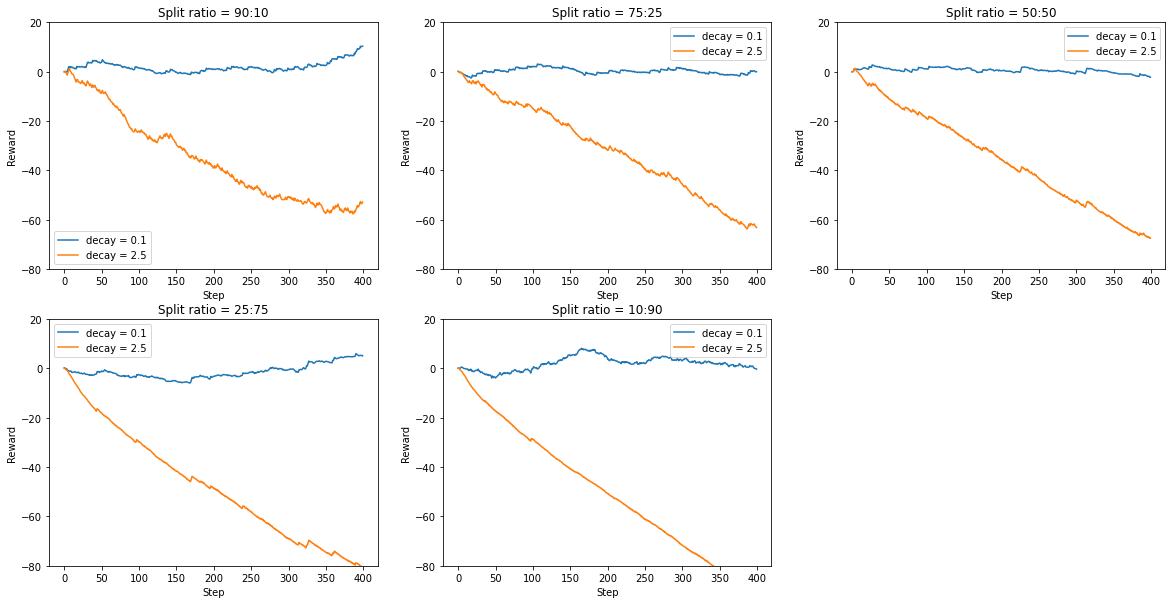

In [23]:
plt.figure(figsize = (20,10))
idx = 1
for name,model in models.items():
    plt.subplot(2,3,idx)
    df = model.datacollector.get_agent_vars_dataframe()
    plt.plot(df[df['Decay'] ==0.1]['Utility'].groupby('Step').mean(),label='decay = 0.1')
    plt.plot(df[df['Decay'] ==2.5]['Utility'].groupby('Step').mean(),label = 'decay = 2.5')
    plt.legend()
    #plt.plot(df['Customers'],label = name)
    plt.ylim([-80
              ,20])
    plt.title('Split ratio = '+name)
    idx = idx + 1 
    plt.ylabel('Reward')
    plt.xlabel('Step')
plt.savefig('Heterogeneity.reward.png',dpi = 300)

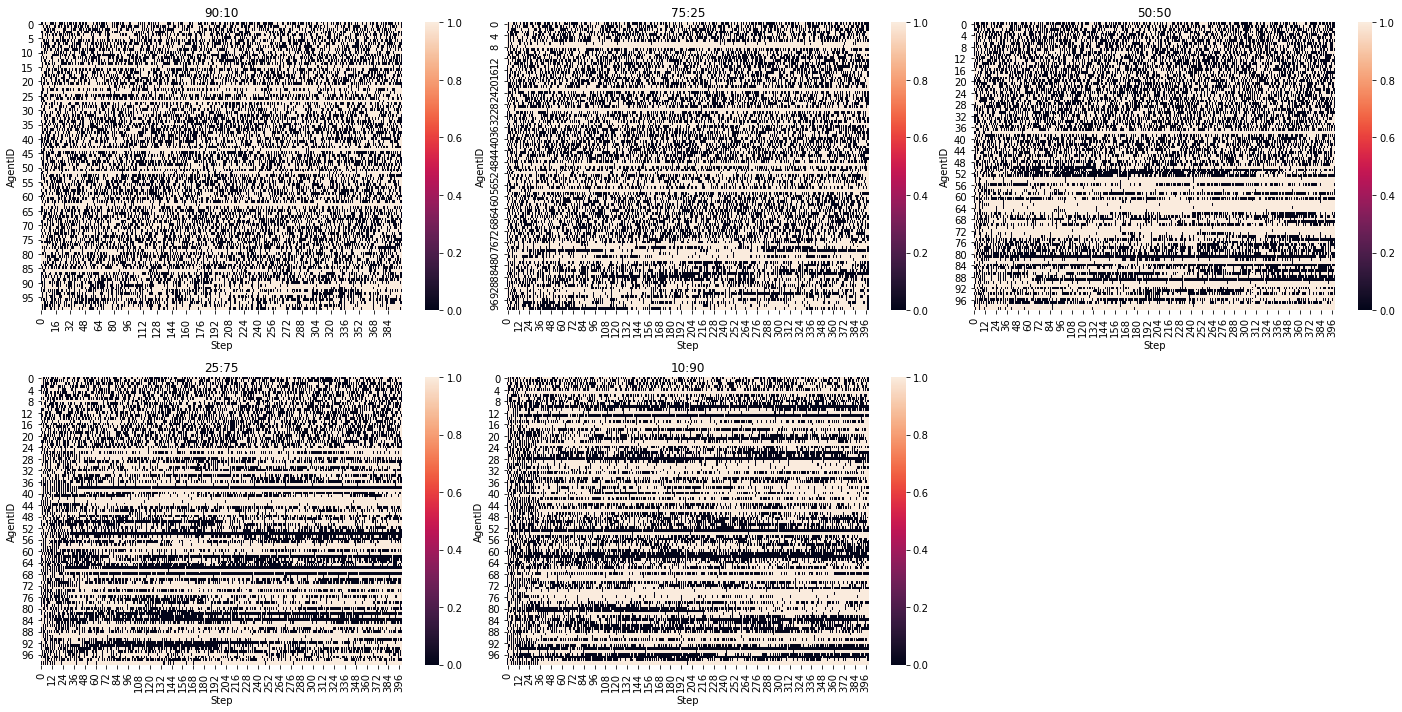

In [21]:
import seaborn as sns
plt.figure(figsize = (20,10))
idx = 1
for name,model in models.items():
    plt.subplot(2,3,idx)
    df = model.datacollector.get_agent_vars_dataframe()
    df.reset_index(inplace=True)
    sns.heatmap(df.pivot(index = "AgentID",columns = "Step",values = "Attendance"))
    plt.tight_layout()
    plt.title(name)
    idx = idx +1
plt.savefig('Heterogeneity.heatmap.png',dpi = 300)

In [149]:
n = 60
trials = 400
rep = 20

decays = [0.1,1,2.5,5]
models = [ElFarolBarIBLT(N=100,crowdthreshold=n,decay = {d:1}) for d in decays for i in range(rep)]
len(models)

80

In [150]:
from tqdm import tqdm

for model in tqdm(models):
    for i in range(trials):
        model.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [05:34<00:00,  4.18s/it]


In [162]:
stds = []
for model in models:
    df = model.datacollector.get_model_vars_dataframe()
    df.reset_index(inplace=True)
    stds.append(df[df['index']>200]['Customers'].std())

In [167]:
np.array(stds).reshape(4,20).mean(axis = 1)

array([ 4.94709967,  7.40787102, 10.38129592,  3.94245314])

In [168]:
np.array(stds).reshape(4,20).std(axis = 1)

array([0.21584043, 0.29378877, 0.87626488, 0.275209  ])

In [171]:
n = 60
trials = 400
decays ={'90:10':{0.1:0.9,2.5:0.1},
        '75:25':{0.1:0.75,2.5:0.25},
        '50:50':{0.1:0.5,2.5:0.5},
        '25:75':{0.1:0.25,2.5:0.75},
        '10:90':{0.1:0.1,2.5:0.9}}
models = [ElFarolBarIBLT(N=100,crowdthreshold=n,decay = d) for name,d in decays.items() for i in range(rep)]

for model in tqdm(models):
    for i in range(trials):
        model.step()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:26<00:00,  4.46s/it]


In [173]:
stds = []
for model in models:
    df = model.datacollector.get_model_vars_dataframe()
    df.reset_index(inplace=True)
    stds.append(df[df['index']>200]['Customers'].std())
print(decays.keys())
print(np.array(stds).reshape(5,20).mean(axis = 1))
print(np.array(stds).reshape(5,20).std(axis = 1))

dict_keys(['90:10', '75:25', '50:50', '25:75', '10:90'])
[5.30848917 6.05490016 7.57271766 8.46971716 9.82139294]
[0.29329266 0.33415943 0.28231604 0.65661377 0.45303968]
